# Реализация CNN в Keras

Реализуем свою свёрточную нейронную сеть с типичной архитектурой:

`Input -> Conv -> Conv -> Pool -> Conv -> Pool -> Dense`

Воспользуемся вторым способом создания моделей. Он называется функциональным. В нём слои создаются как самостоятельные объекты. Для соединения слоёв явно указывается выход какого слоя поступает на вход. Такой подход является более гибким и позволяет создавать более сложные архитектуры. 

*N.B. В данном случае хватило бы и Sequintal, функциональный подход используется для введения в курс дела, потому что дальше нас ждёт Transfer Learning, а там только функциональный*

In [ ]:
import tensorflow as tf
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Activation, Dropout, Input, Flatten, BatchNormalization
from keras.datasets import mnist
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

# Поскольку у сети 10 выходов, необходимо вектор из N ответа представить в виде [N, 10]. Такое кодирование называется One Hot Encoding (OHE). 
# Например, в случае трёх признаков вектор ответов [0, 2, 1] превратится в [[1, 0, 0], [0, 0, 1], [0, 1, 0]].
def OHE(x):
    y = np.zeros(shape=(x.size, 10))
    y[np.arange(x.size), x] = 1
    return y

# Подгружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# И начинаем собирать модель:
model = Model()

# Начинаем создавать и группировать слои:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation='relu')(inputs)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Conv2D(64, 3, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = MaxPool2D()(x)

x = Conv2D(128, 3, activation='relu')(x)
x = Dropout(0.2)(x)

x = MaxPool2D()(x)

x = BatchNormalization()(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Выбираем оптимизатор, функцию потерь и метрики
# optimizer = SGD(lr=0.01, momentum=0.8, nesterov=True)
optimizer = Adam(lr=0.005, amsgrad=True)
loss = categorical_crossentropy
metrics = [categorical_accuracy]  # Метрики задаются списком. Стало быть, можно использовать несколько.

# После чего собираем модель
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

# Осталось подготовить данные:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  # Сделаем из картинок плоские вектора
x_train = x_train.astype(float) / 255  # Отнормируем вектор признаков от 0 до 1. 
y_train_OHE = OHE(y_train)  # И закодируем вектор ответов при помощи OHE

# Сделаем то же самое с валидационными данными:
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype(float) / 255
y_test_OHE = OHE(y_test)

# Всё, модель можно обучать:
model.fit(x_train, y_train_OHE, 
          epochs=20, 
          batch_size=32, 
          validation_data=(x_test, y_test_OHE));

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_13 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_14 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 24, 24, 64)        256       
__________

Total mismatches: 84; Accuracy = 99.16%


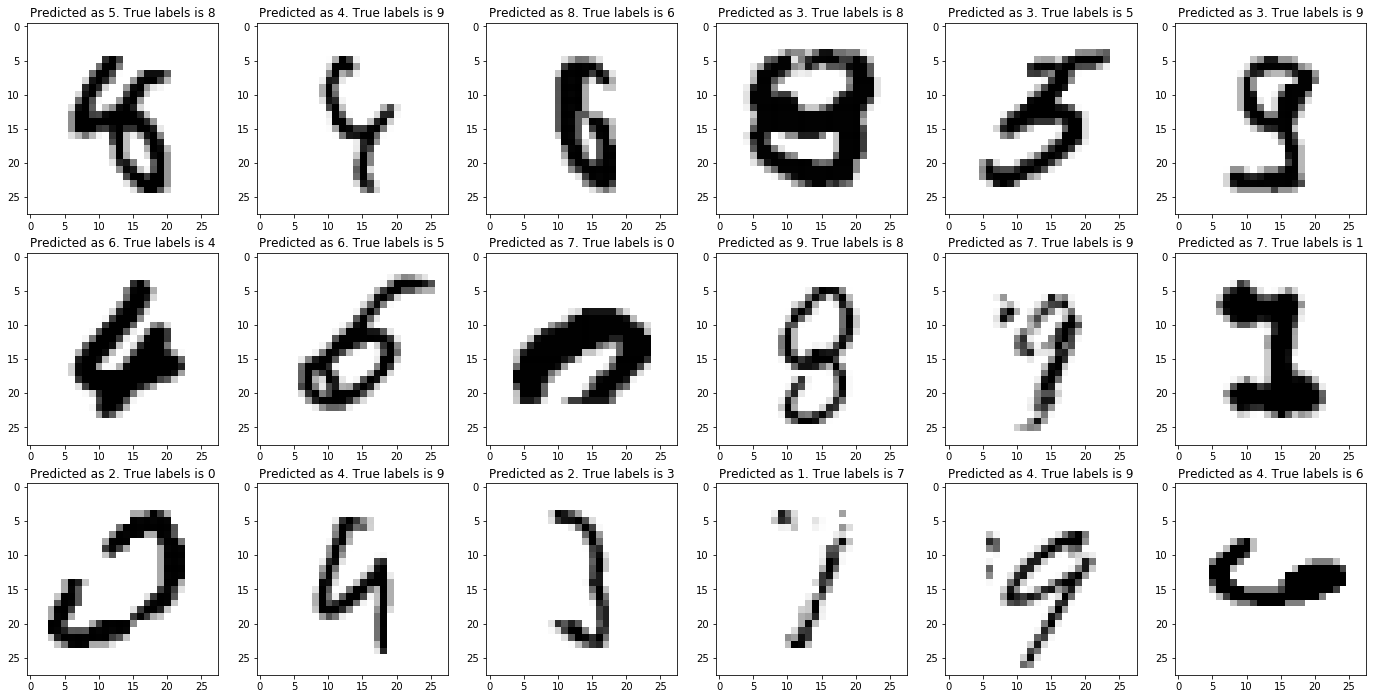

In [18]:
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Масштабируем тестовые признаки
x_test = x_test.reshape(-1, 28, 28, 1).astype('float')
x_test /= 255

# Прогоняем новые признаки через сеть методом model.predict()
pred = model.predict(x_test)

# Выходной вектор выглядит выглядит как [[p_10, p_11, ... p_19], [p_20, p_21, ...], ...[...p_N0]], где p_ij - вероятность пренадлежность объекта i классу j
predicted_class = np.argmax(pred, axis=1) # Приведём его к виду [class_1, class_2, ..., class_N]

match = predicted_class == y_test # Оценим точность как количество правильно угаданных классов
mismatch = ~match
print(f'Total mismatches: {mismatch.sum()}; Accuracy = {match.mean() * 100}%')

x = x_test[mismatch].reshape(-1, 28, 28)
y = y_test[mismatch]
p = predicted_class[mismatch]

fig, axes = plt.subplots(3, 6, figsize=(24, 12));
samples = np.random.choice(np.arange(y.size), axes.size, replace=False)
for i, ax in zip(samples, axes.ravel()):
    ax.imshow(x[i], cmap='gray_r')
    ax.set_title(f'Predicted as {p[i]}. True labels is {y[i]}')
    
plt.show();